https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [21]:
import pandas as pd
import numpy as np
from sklearn.impute import *

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
y = train.SalePrice

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
data = pd.concat([train, test])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [6]:
# list(filter(lambda column: (data[column].count() != data.shape[0]), data.keys()))
columns_with_nan = {column: data[column].count() for column in data.keys() if data[column].count() != data.shape[0]}
columns_with_nan

{'MSZoning': 2915,
 'LotFrontage': 2433,
 'Alley': 198,
 'Utilities': 2917,
 'Exterior1st': 2918,
 'Exterior2nd': 2918,
 'MasVnrType': 2895,
 'MasVnrArea': 2896,
 'BsmtQual': 2838,
 'BsmtCond': 2837,
 'BsmtExposure': 2837,
 'BsmtFinType1': 2840,
 'BsmtFinSF1': 2918,
 'BsmtFinType2': 2839,
 'BsmtFinSF2': 2918,
 'BsmtUnfSF': 2918,
 'TotalBsmtSF': 2918,
 'Electrical': 2918,
 'BsmtFullBath': 2917,
 'BsmtHalfBath': 2917,
 'KitchenQual': 2918,
 'Functional': 2917,
 'FireplaceQu': 1499,
 'GarageType': 2762,
 'GarageYrBlt': 2760,
 'GarageFinish': 2760,
 'GarageCars': 2918,
 'GarageArea': 2918,
 'GarageQual': 2760,
 'GarageCond': 2760,
 'PoolQC': 10,
 'Fence': 571,
 'MiscFeature': 105,
 'SaleType': 2918}

In [7]:
#Sorting the vector from the smallest amount of NaN to the largest 
ordered_columns_by_nan_count = [key for key, value in sorted(columns_with_nan.items(), key=lambda item: item[1])][::-1]
ordered_columns_by_nan_count

['SaleType',
 'GarageArea',
 'GarageCars',
 'KitchenQual',
 'Electrical',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1',
 'Exterior2nd',
 'Exterior1st',
 'Functional',
 'BsmtHalfBath',
 'BsmtFullBath',
 'Utilities',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'BsmtExposure',
 'BsmtCond',
 'GarageType',
 'GarageCond',
 'GarageQual',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'FireplaceQu',
 'Fence',
 'Alley',
 'MiscFeature',
 'PoolQC']

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import *
from xgboost import XGBClassifier

def doMethodImpute(data, target_column, model=DecisionTreeRegressor):
    class doMethodImputeIntern():
        def __init__(self, target_column, not_append, to_append, onehotencoder, model):
            self.target_column = target_column
            self.not_append = not_append
            self.to_append = to_append
            self.onehotencoder = onehotencoder
            self.model = model

        def transform(self, new_data):
            Xt = self.onehotencoder.transform(new_data[self.to_append]).toarray()
            Xt = np.concatenate((Xt, new_data[self.not_append]), axis=1)
            ypt = self.model.predict(Xt)

            news_data[self.target_column].fillna(pd.Series(ypt), inplace=True)

            return self

    columns_to_fit = []
    for key in data.keys():
        if key == target_column: continue
        if data[target_column].notnull().sum() == data[data[target_column].notnull()][key].notnull().sum():
            columns_to_fit.append(key)

    not_append, to_append = [], []
    for column in columns_to_fit:
        if data[column].dtype == np.float64 or data[column].nunique() > 5:
            if data[column].dtype == object:
                continue
            not_append.append(column)
        else:
            to_append.append(column)

    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    categorical = data[data[target_column].notnull()][to_append]
    X = onehotencoder.fit_transform(categorical).toarray()
    X = np.concatenate((X, data[data[target_column].notnull()][not_append]), axis=1)

    model = model()
    model.fit(X, data[data[target_column].notnull()][target_column])
    yp = model.predict(X)

    Xt = onehotencoder.transform(data[to_append].fillna(0)).toarray()
    Xt = np.concatenate((Xt, data[not_append]), axis=1)
    np.nan_to_num(Xt, copy=False)
    ypt = model.predict(Xt)

    data[target_column].fillna(pd.Series(ypt), inplace=True)

    return doMethodImputeIntern(target_column, not_append, to_append, onehotencoder, model)

In [9]:
from pandas.api.types import is_integer_dtype

#impute nan with regression if at least 50% of the feature is not Nan 
for col in ordered_columns_by_nan_count:
    print(col)
    if columns_with_nan[col] > 0.5*data.shape[0]:
        if data[col].dtype == np.float64 or (is_integer_dtype(data[col].dtype) and data[col].nunique() > 5):
            model=DecisionTreeRegressor
            doMethodImpute(data, col, model=model)
        elif data[col].nunique() <= 5:
            model=XGBClassifier
            doMethodImpute(data, col, model=model)
        else:
            data.fillna({col: 'notEvaluated'}, inplace=True)
    else:
        if data[col].dtype == np.float64 or is_integer_dtype(data[col].dtype):
            imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')
            imputer = imputer.fit(data[[col]])
            data[[col]] = imputer.transform(data[[col]])
        else:
            data.fillna({col: 'notEvaluated'}, inplace=True)


SaleType
GarageArea
GarageCars
KitchenQual


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Electrical


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TotalBsmtSF
BsmtUnfSF
BsmtFinSF2
BsmtFinSF1
Exterior2nd
Exterior1st
Functional
BsmtHalfBath
BsmtFullBath
Utilities


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
MSZoning


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
MasVnrArea
MasVnrType


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BsmtFinType1
BsmtFinType2
BsmtQual


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BsmtExposure


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BsmtCond


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GarageType
GarageCond


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GarageQual


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GarageFinish


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GarageYrBlt
LotFrontage
FireplaceQu


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:21:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fence
Alley
MiscFeature
PoolQC


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [11]:
data['MiscVal'].skew(), data['GarageArea'].skew()

(21.958480324447216, 0.24108095236345972)

<AxesSubplot:>

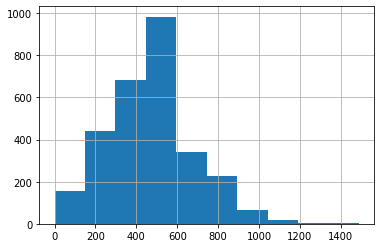

In [12]:
data['GarageArea'].hist()

<AxesSubplot:>

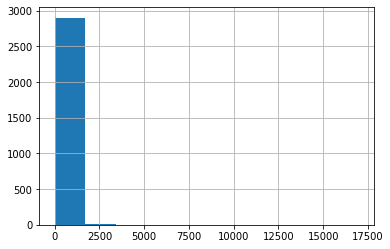

In [13]:
data['MiscVal'].hist()

In [14]:
for col in data.keys():
    if data[col].dtype == np.float64 or is_integer_dtype(data[col].dtype):
        print(f"{col}:\t{data[col].skew()}:\t{min(data[col])}")

MSSubClass:	1.3761646373261713:	20
LotFrontage:	1.3678725453228033:	21.0
LotArea:	12.829024853018762:	1300
OverallQual:	0.19721180528040133:	1
OverallCond:	0.5706053117352524:	1
YearBuilt:	-0.6001139748696814:	1872
YearRemodAdd:	-0.45125229728739846:	1950
MasVnrArea:	2.6034915776004643:	0.0
BsmtFinSF1:	1.4259630549308222:	0.0
BsmtFinSF2:	4.148275267275402:	0.0
BsmtUnfSF:	0.9193562952937085:	0.0
TotalBsmtSF:	1.1634099122462143:	0.0
1stFlrSF:	1.4703601055379227:	334
2ndFlrSF:	0.8621178325657642:	0
LowQualFinSF:	12.094977192517302:	0
GrLivArea:	1.2700104075191514:	334
BsmtFullBath:	0.6236581970539314:	0.0
BsmtHalfBath:	3.9336155129159094:	0.0
FullBath:	0.16769191818882379:	0
HalfBath:	0.6949236492716564:	0
BedroomAbvGr:	0.32649214927079917:	0
KitchenAbvGr:	4.304466641562935:	0
TotRmsAbvGrd:	0.7587568676624701:	2
Fireplaces:	0.733871770878103:	0
GarageYrBlt:	-0.3871613144587938:	1895.0
GarageCars:	-0.21870492080546935:	0.0
GarageArea:	0.24108095236345972:	0.0
WoodDeckSF:	1.8433802126628294

In [15]:
from sklearn.preprocessing import StandardScaler

for col in data.keys():
    if data[col].dtype == np.float64 or (is_integer_dtype(data[col].dtype) and data[col].nunique() > 5):
        if min(data[col]) > 0 and data[col].skew() > 1:
            data[col] = np.log(data[col])

        enc = StandardScaler()
        enc = enc.fit(data[col].to_numpy().reshape(-1, 1))
        data[col] = enc.transform(data[col].to_numpy().reshape(-1, 1))

        print(f"{col}:\t{data[col].skew()}:\t{min(data[col])}")


MSSubClass:	0.229244897249098:	-1.1245468601517488
LotFrontage:	-0.8377261708868143:	-3.1649038612248606
LotArea:	-0.505542201625112:	-3.7747547591722426
OverallQual:	0.19721180528040172:	-3.6100242015631046
OverallCond:	0.5706053117352512:	-4.101368143895511
YearBuilt:	-0.6001139748696795:	-3.2791372456655576
YearRemodAdd:	-0.4512522972874003:	-1.6401732676732679
MasVnrArea:	2.6034915776004643:	-0.5693463311699288
BsmtFinSF1:	1.4259630549308222:	-0.9687045443918657
BsmtFinSF2:	4.148275267275401:	-0.2930252797528886
BsmtUnfSF:	0.9193562952937085:	-1.2763625483181664
TotalBsmtSF:	1.1634099122462151:	-2.3867237084112056
1stFlrSF:	0.06389503599930141:	-3.691812829511027
2ndFlrSF:	0.8621178325657642:	-0.7850250438866518
LowQualFinSF:	12.094977192517305:	-0.10119701650206231
GrLivArea:	0.012385663552307842:	-4.461264778128587
BsmtFullBath:	0.6236581970539318:	-0.8195105027321054
BsmtHalfBath:	3.9336155129159116:	-0.24971861037228732
BedroomAbvGr:	0.3264921492707981:	-3.4772579968666792
TotR

In [16]:
from sklearn.preprocessing import *

categorical_features = []
no_categorical_features = []
for col in data.keys():
    if data[col].dtype == object or (is_integer_dtype(data[col].dtype) and data[col].nunique() <= 5):
        categorical_features.append(col)
    else:
        no_categorical_features.append(col)

cat = data[categorical_features]
not_cat = data[no_categorical_features]
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(cat).toarray()

X = np.concatenate([X, not_cat], axis=1)

In [17]:
df_X = pd.DataFrame(X)
train_imputed = df_X.head(train.shape[0]).copy()
test_imputed = df_X.tail(test.shape[0]).copy()

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_imputed, y, test_size=0.10, random_state=42)

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

yp = model.predict(X_test)

print(np.sqrt(mean_squared_log_error(y_test, yp)))

0.17383294800973484


In [20]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(train_imputed, y)
yp = model.predict(test_imputed)

with open('pred.csv', 'w') as out, open('/kaggle/input/house-prices-advanced-regression-techniques/test.csv') as inp:
    out.write('Id,SalePrice\n')
    inp.readline()
    for v in yp:
        line = inp.readline().split(",")[0]
        out.write(line + "," + str(int(v)) + "\n")